# Generar dato inicial

Sampleo desde 5 distribuciones gaussiana cuyos centroides han sido sampleados a partir de una distribucion uniforme.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from pathlib import Path

In [2]:
def generate_centroids(df):
    # Calculate centroids for each site
    return df.groupby('Site').mean().values

def generate_PCA(data, n_components, centroids, n_sites, n_samples_per_site):
    # Apply PCA to reduce the data to the specified number of components
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    # Transform the centroids into the PCA space
    centroids_pca = pca.transform(centroids)

    # Create a DataFrame for the PCA-transformed data
    df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

    # Create the 'Site' labels based on the number of sites and samples per site
    labels = np.repeat(np.arange(n_sites), n_samples_per_site)
    df_pca['Site'] = labels

    # Create a DataFrame for the PCA-transformed centroids
    centroids_pca_df = pd.DataFrame(centroids_pca, columns=['PC1', 'PC2'])

    # Ensure that centroids are correctly labeled by site (you can directly use the range)
    centroids_pca_df['Site'] = np.arange(n_sites)

    plt.figure(figsize=(10, 6))

    # Scatter plot of the PCA-transformed data
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Site',
        data=df_pca,
        palette='viridis',
        alpha=0.6,
        s=80,
        legend='full'
    )

    # Overlay the centroids
    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Site',
        data=centroids_pca_df,
        palette='viridis',
        marker='X',
        s=200,
        edgecolor='black',
        linewidth=1.5,
        legend=False
    )

    # Annotate the centroids with site numbers
    for i, row in centroids_pca_df.iterrows():
        plt.text(row['PC1'], row['PC2'], f'Site {i}', fontsize=12, ha='right', va='bottom')

    plt.title("PCA of Data with Cluster Centroids (2D)")
    plt.xlabel("Principal Component 1 (PC1)")
    plt.ylabel("Principal Component 2 (PC2)")
    plt.legend(title='Site')
    plt.show()

def show_centroid_distances(centroids, n_sites):

    # Compute pairwise distances between centroids
    pairwise_distances = euclidean_distances(centroids)

    # Convert to a DataFrame for better readability
    distance_df = pd.DataFrame(pairwise_distances, index=range(n_sites), columns=range(n_sites))
    print("\nPairwise distances between centroids:")
    print(distance_df)

    plt.figure(figsize=(8, 6))
    sns.heatmap(distance_df, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
    plt.title("Pairwise Distances Between Cluster Centroids")
    plt.xlabel("Site")
    plt.ylabel("Site")
    # plt.savefig("pairwise_distances_heatmap.png")
    plt.show()

Samples per site:
Site
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64


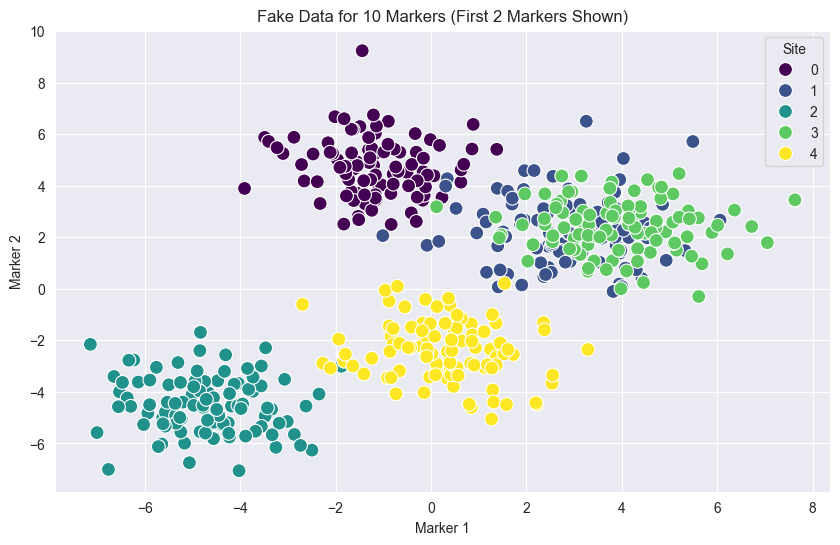


First few rows of the dataset:
   Marker_1  Marker_2  Marker_3  Marker_4  Marker_5  Marker_6  Marker_7  \
0 -1.199297  4.782086  2.515219  0.619655 -2.160221 -5.697929 -5.276100   
1 -2.322797  3.306922  4.047006  0.473959 -3.384463 -3.793668 -4.099775   
2 -1.548479  3.704053  1.589545  2.004571 -3.253699 -4.174168 -3.838212   
3 -2.470559  5.227553  3.900370  0.928511 -3.016121 -3.760413 -5.984000   
4 -0.172710  3.434149  2.331242  0.799404 -3.869721 -2.698042 -3.663317   

   Marker_8  Marker_9  Marker_10  Site  
0  3.198429 -0.327390   2.153030     0  
1  3.990846 -0.120842   2.516439     0  
2  3.227911  0.607131  -0.611132     0  
3  3.383747  0.876673   2.349652     0  
4  4.257230  0.159156   2.357878     0  


In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_sites = 5      # Number of sites (clusters)
n_samples = n_sites * 100  # Total number of samples
n_features = 10  # Number of markers (features)

samples_per_site = n_samples // n_sites  # Equal number for each site

# Initialize empty arrays
data = np.zeros((n_samples, n_features))
labels = np.zeros(n_samples, dtype=int)

# Generate data for each site separately
for site in range(n_sites):
    # Define a different mean vector for each site
    mean_vector = np.random.uniform(-5, 5, size=n_features)

    # Generate data for this site
    site_data = np.random.multivariate_normal(
        mean=mean_vector,
        cov=np.eye(n_features),  # Identity covariance matrix
        size=samples_per_site
    )

    # Add some site-specific variability
    noise = np.random.normal(loc=0, scale=0.5, size=site_data.shape)
    site_data = site_data + noise

    # Store in the main arrays
    start_idx = site * samples_per_site
    end_idx = start_idx + samples_per_site
    data[start_idx:end_idx] = site_data
    labels[start_idx:end_idx] = site

# Handle any remaining samples due to integer division
remaining = n_samples - (samples_per_site * n_sites)
if remaining > 0:
    for i in range(remaining):
        site = i % n_sites
        mean_vector = np.random.uniform(-5, 5, size=n_features)
        extra_sample = np.random.multivariate_normal(mean=mean_vector, cov=np.eye(n_features), size=1)
        data[samples_per_site * n_sites + i] = extra_sample
        labels[samples_per_site * n_sites + i] = site

# Create a DataFrame
columns = [f"Marker_{i+1}" for i in range(n_features)]
df = pd.DataFrame(data, columns=columns)
df['Site'] = labels

# Check the distribution of samples per site
site_counts = df['Site'].value_counts().sort_index()
print("Samples per site:")
print(site_counts)

# Visualize the data (first 2 markers for simplicity)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Marker_1'], y=df['Marker_2'], hue=df['Site'], palette='viridis', s=100)
plt.title("Fake Data for 10 Markers (First 2 Markers Shown)")
plt.xlabel("Marker 1")
plt.ylabel("Marker 2")
plt.legend(title='Site')
# plt.savefig("site_markers_plot.png")
plt.show()

# Display the first few rows of the data
print("\nFirst few rows of the dataset:")
print(df.head())

# Mostrar distancias entre centroides del dato sampleado

In [4]:
centroids = generate_centroids(df)
print("Centroids for each site:")
print(centroids)

Centroids for each site:
[[-1.18595362  4.68902769  2.36111577  1.03209406 -3.46807198 -3.35759817
  -4.26817127  3.5948992   0.92709543  2.19237535]
 [ 2.85991782  2.25919228 -4.59522224 -4.46965199 -0.88444698 -1.94388951
  -2.64373437 -2.09181357  3.02969656  4.15106031]
 [-4.6885943  -4.51634852  3.35304521 -3.97586806 -4.58027514 -0.76751471
   3.38621001 -2.39152733 -0.92718897 -4.62047057]
 [ 3.926563    2.40961374  0.11153605  0.9865411  -1.82979365  4.85505925
   1.59176502 -4.59025269 -1.69368936  1.19448022]
 [ 0.28652851 -2.40850287 -3.15244226 -4.28538513  2.44572024 -0.52779729
   1.14240389  2.11560763  1.80009438 -0.301734  ]]



Pairwise distances between centroids:
           0          1          2          3          4
0   0.000000  12.362912  16.592067  14.687675  13.879629
1  12.362912   0.000000  17.618074  12.467428   9.848713
2  16.592067  17.618074   0.000000  15.458230  13.132882
3  14.687675  12.467428  15.458230   0.000000  13.482644
4  13.879629   9.848713  13.132882  13.482644   0.000000


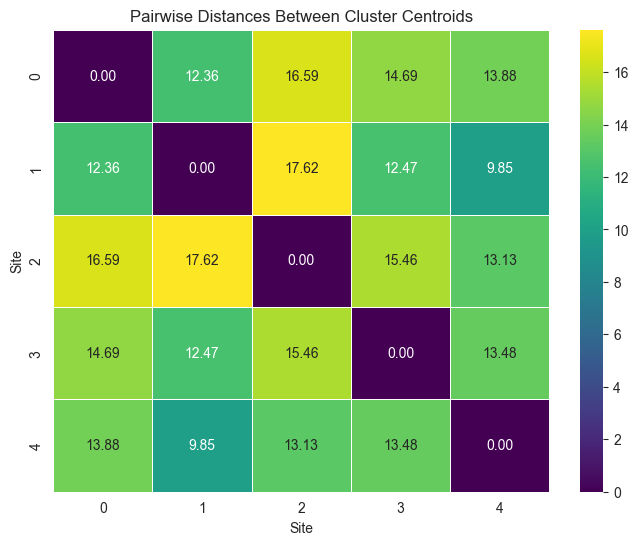

In [5]:
show_centroid_distances(centroids, n_sites)

# Aplicar PCA-2D y mostrar separacion entre sites

/Users/fernando/Documents/GitHub/visualization-tool-heparin/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


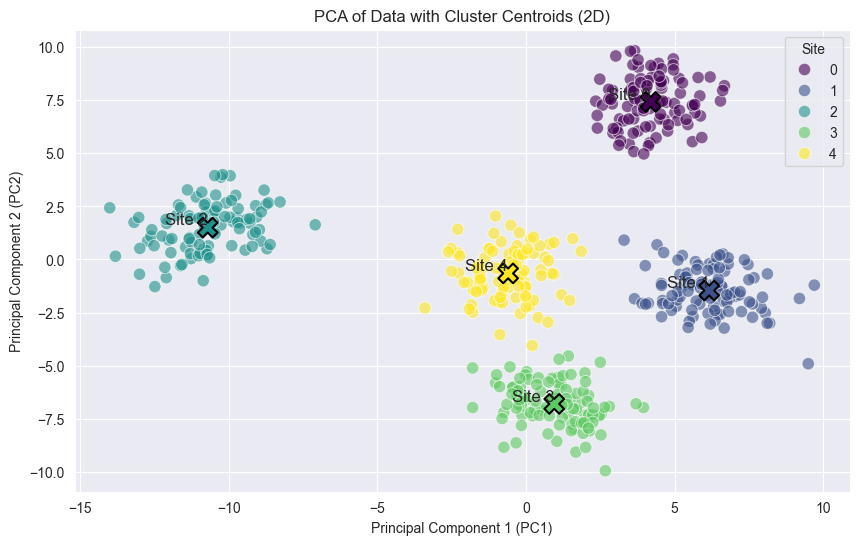

In [6]:
generate_PCA(
    data=df.drop(columns=["Site"]),
    n_components=2,
    centroids=centroids,
    n_sites=n_sites,
    n_samples_per_site=samples_per_site
)

# Generar datos para diferentes años

Usaremos los datos anteriores como el último año y tendremos años previos con un número diferente de sitios. Luego combinaremos todos los datos en un único DataFrame y lo guardaremos como un CSV para su uso en la visualización.

Vamos a simular que:
* Site 0 se mantiene estable
* Site 1 se mantiene estable
* Site 2 en el primer año tiene media de site 2, en el segundo año tiene de media la 1/3 entre site 2 y site 3 y en el tercer año 2/3 de la media entre site 2 y 3.

In [7]:
df_year_3 = df

## Samplear año 2 (4 sites)

En el segundo año el site 1 se encuentra en la media ponderada 75% cerca de su valor real entre 1 y 2

In [8]:
import numpy as np
import pandas as pd

# Crear un nuevo DataFrame para almacenar los datos generados
df_year_2 = pd.DataFrame(columns=df.columns)

# Generar datos para cada site (0-4) con una gaussiana
n_sites_year_2 = 4
num_samples = 100  # Número de instancias por site
for site in range(n_sites_year_2):
    site_data = df[df['Site'] == site]
    mean_vector = site_data.mean().values[:-1]  # Excluye la columna 'Site'
    cov_matrix = np.cov(site_data.iloc[:, :-1], rowvar=False)  # Matriz de covarianza

    # Ajustar la media y varianza del site 2 como el promedio entre site 2 y site 3
    if site == 0:
        site_1_data = df[df['Site'] == 1]
        mean_vector = site_data.mean().values[:-1] * (0.75) + site_1_data.mean().values[:-1] * (0.25)
        cov_matrix = np.cov(site_data.iloc[:, :-1], rowvar=False) * (0.75) + np.cov(site_1_data.iloc[:, :-1], rowvar=False) * (0.25)

    # Generar nuevas muestras
    sampled_data = np.random.multivariate_normal(mean=mean_vector, cov=cov_matrix, size=num_samples)

    # Crear DataFrame temporal y agregar columna 'Site'
    temp_df = pd.DataFrame(sampled_data, columns=df.columns[:-1])
    temp_df['Site'] = site

    # Agregar al nuevo DataFrame
    df_year_2 = pd.concat([df_year_2, temp_df], ignore_index=True)

# Mostrar los primeros registros del nuevo DataFrame
df_year_2.head()

/var/folders/47/gybx85kd6f147h3rp8wgdz9w0000gn/T/ipykernel_35302/2402056176.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_year_2 = pd.concat([df_year_2, temp_df], ignore_index=True)


,Marker_1,Marker_2,Marker_3,Marker_4,Marker_5,Marker_6,Marker_7,Marker_8,Marker_9,Marker_10,Site
0,1.013605,2.747957,-0.059660,-1.449226,-3.607511,-2.782220,-3.662300,2.587667,0.470990,2.714542,0
1,0.435735,4.661804,-0.489593,-1.885351,-3.169599,-3.063224,-2.973176,1.141710,2.223472,3.758159,0
2,-1.543809,2.811439,1.386833,-0.268480,-2.079790,-2.050646,-2.821552,0.574724,1.394073,0.677465,0
3,-0.328791,4.386027,0.578699,-0.118151,-1.286208,-4.007367,-3.931886,2.730404,0.962387,2.246380,0
4,-1.176152,2.965279,2.534491,0.804278,-2.264717,-2.977712,-4.457524,1.917452,-0.286756,1.316129,0


## Samplear año 1 (3 sites)

En el primer año el site 1 se encuentra en un valor medio entre site 1 y 2

In [9]:
import numpy as np
import pandas as pd

# Crear un nuevo DataFrame para almacenar los datos generados
df_year_1 = pd.DataFrame(columns=df.columns)

n_sites_year_1 = 3

# Generar datos para cada site (0-4) con una gaussiana
num_samples = 100  # Número de instancias por site
for site in range(n_sites_year_1):
    site_data = df[df['Site'] == site]
    mean_vector = site_data.mean().values[:-1]  # Excluye la columna 'Site'
    cov_matrix = np.cov(site_data.iloc[:, :-1], rowvar=False)  # Matriz de covarianza

    # Ajustar la media y varianza del site 2 como el promedio entre site 2 y site 3
    if site == 0:
        site_1_data = df[df['Site'] == 1]
        mean_vector = site_data.mean().values[:-1] * (0.5) + site_1_data.mean().values[:-1] * (0.5)
        cov_matrix = np.cov(site_data.iloc[:, :-1], rowvar=False) * (0.5) + np.cov(site_1_data.iloc[:, :-1], rowvar=False) * (0.5)

    # Generar nuevas muestras
    sampled_data = np.random.multivariate_normal(mean=mean_vector, cov=cov_matrix, size=num_samples)

    # Crear DataFrame temporal y agregar columna 'Site'
    temp_df = pd.DataFrame(sampled_data, columns=df.columns[:-1])
    temp_df['Site'] = site

    # Agregar al nuevo DataFrame
    df_year_1 = pd.concat([df_year_1, temp_df], ignore_index=True)

# Mostrar los primeros registros del nuevo DataFrame
df_year_1.head()

/var/folders/47/gybx85kd6f147h3rp8wgdz9w0000gn/T/ipykernel_35302/717522846.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_year_1 = pd.concat([df_year_1, temp_df], ignore_index=True)


,Marker_1,Marker_2,Marker_3,Marker_4,Marker_5,Marker_6,Marker_7,Marker_8,Marker_9,Marker_10,Site
0,1.159344,4.549441,-1.216054,-0.940226,-2.728168,-1.797343,-5.103201,-0.111248,3.292528,3.565921,0
1,0.902053,3.555514,0.152328,-2.833635,-2.037862,-4.104607,-3.479031,0.964140,1.663273,2.545804,0
2,-1.165797,5.371242,-0.636158,-0.763557,-1.382566,-3.217981,-4.619269,-1.020446,1.756581,1.749869,0
3,-0.644149,3.885799,-0.104654,-1.981998,-1.278382,-3.125083,-4.496831,2.892835,2.293375,3.877581,0
4,2.124324,2.212329,-2.179794,-1.811589,-1.521935,-2.525114,-2.670062,0.678601,3.204724,3.601884,0


# Mostrar como se mueven los centroides a lo largo del tiempo

Basicamente con lo hecho anteriormente los site 0 y 1 se van alejando segun pasa el tiempo


Pairwise distances between centroids:
           0          1          2
0   0.000000   6.121922  15.830213
1   6.121922   0.000000  17.373141
2  15.830213  17.373141   0.000000


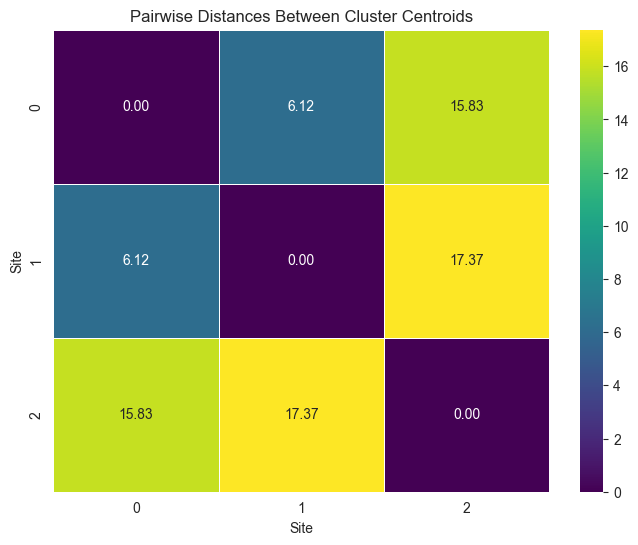

In [10]:
# generate_PCA(
#     data=df_year_1.drop(columns=["Site"]),
#     n_components=2,
#     centroids=generate_centroids(df_year_1),
#     n_sites=3,
#     n_samples_per_site=samples_per_site
# )

show_centroid_distances(
    centroids=generate_centroids(df_year_1),
    n_sites=n_sites_year_1,
)


Pairwise distances between centroids:
           0          1          2          3
0   0.000000   9.041263  16.103684  13.102982
1   9.041263   0.000000  17.701039  12.307694
2  16.103684  17.701039   0.000000  15.466716
3  13.102982  12.307694  15.466716   0.000000


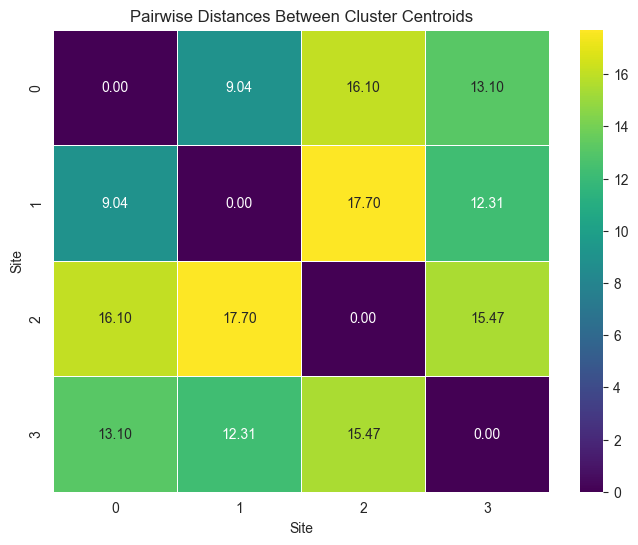

In [11]:
# generate_PCA(
#     data=df_year_2.drop(columns=["Site"]),
#     n_components=2,
#     centroids=generate_centroids(df_year_2),
#     n_sites=4,
#     n_samples_per_site=samples_per_site
# )

show_centroid_distances(
    centroids=generate_centroids(df_year_2),
    n_sites=n_sites_year_2,
)


Pairwise distances between centroids:
           0          1          2          3          4
0   0.000000  12.362912  16.592067  14.687675  13.879629
1  12.362912   0.000000  17.618074  12.467428   9.848713
2  16.592067  17.618074   0.000000  15.458230  13.132882
3  14.687675  12.467428  15.458230   0.000000  13.482644
4  13.879629   9.848713  13.132882  13.482644   0.000000


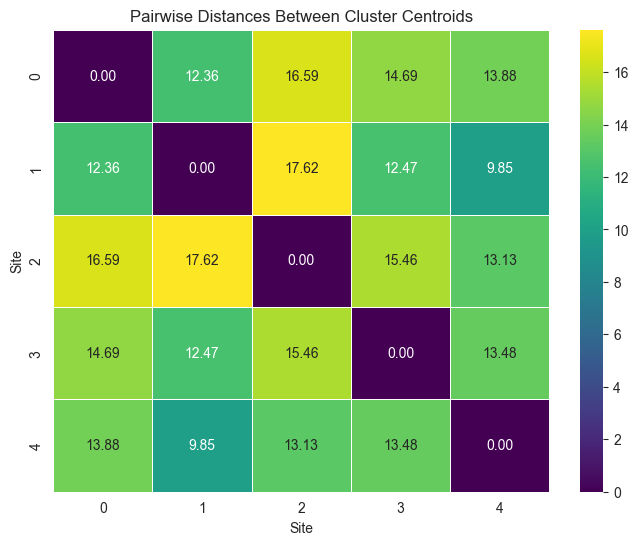

In [12]:
# generate_PCA(
#     data=df_year_3.drop(columns=["Site"]),
#     n_components=2,
#     centroids=generate_centroids(df_year_3),
#     n_sites=5,
#     n_samples_per_site=samples_per_site
# )

show_centroid_distances(
    centroids=generate_centroids(df_year_3),
    n_sites=n_sites,
)

# Agrupar dato de años

In [13]:
# Add a "Year" column to each DataFrame before concatenation
df_year_1['Year'] = 2000
df_year_2['Year'] = 2001
df_year_3['Year'] = 2002

# Concatenate the DataFrames
df_final = pd.concat([df_year_1, df_year_2, df_year_3], ignore_index=True)

# Mapa de renombrado
site_map = {
    0: 'Madrid',
    1: 'Barcelona',
    2: 'Valencia',
    3: 'Sevilla',
    4: 'Oviedo'
}

# Renombrar la columna 'Site' utilizando el mapa
df_final['Site'] = df_final['Site'].replace(site_map)

## Exportar dato

In [14]:
# Define the directory and file path
data_dir = Path('data')
output_file = data_dir / 'heparin.csv'

# Create the data directory if it doesn't exist
data_dir.mkdir(parents=True, exist_ok=True)

# Export the DataFrame to the CSV file
df_final.to_csv(output_file, index=False)